# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/object_detection/g3doc/installation.md) before you start.

# Imports

In [219]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from utils import label_map_util

from utils import visualization_utils as vis_util

## Object detection imports
Here are the imports from the object detection module.

In [220]:
from utils import label_map_util

from utils import visualization_utils as vis_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [221]:
# What model to download.
MODEL_NAME = 'kitti_frozen'

# Path tofrozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'kitti_map.pbtxt')

NUM_CLASSES = 9

## Load a (frozen) Tensorflow model into memory.

In [224]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')


## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [223]:
PATH_TO_LABELS = os.path.join('data', 'kitti_map.pbtxt')
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, 
                                                            max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

## Helper code

In [225]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [226]:
PATH_TO_TEST_IMAGES_DIR = '/Users/shleifer/voc_kitti/VOC2012/JPEGImages/'
p = '/Users/shleifer/voc_kitti/VOC2012/JPEGImages/1023.jpg'
TEST_IMAGE_PATHS = [ p]
FIGSIZE = (20, 20)

In [227]:
import glob
paths = glob.glob(PATH_TO_TEST_IMAGES_DIR + '*')

In [228]:
from utils.np_box_list import BoxList

In [233]:
image_path = paths[0]

In [240]:
#img_id = os.path.basename(image_path)[:-4]

In [ ]:
ls kitti_data/t

In [229]:
from create_dataset import xml_to_dict

In [234]:
def get_annotations(image_path):
    img_id = os.path.basename(image_path)[:-4]
    annotation_path = os.path.join(
    os.path.split(os.path.dirname(image_path))[0], 'Annotations',
    '{}.xml'.format(img_id)
    )
    return xml_to_dict(annotation_path)

In [235]:
data = get_annotations(image_path)

In [242]:
from utils.kitti import show_groundtruth

(6, 4)


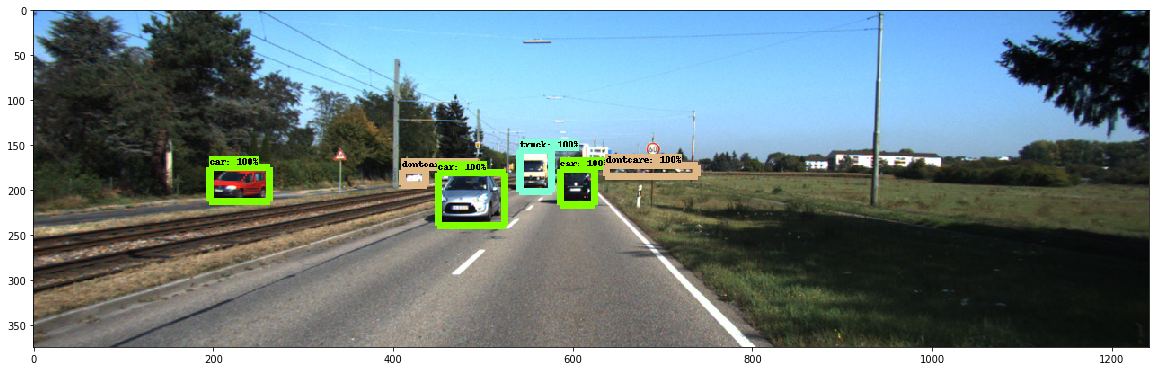

In [243]:
plt.figure(figsize=FIGSIZE)


[ 0.45966983  0.70666301  0.79933381  0.75126874]
(1, 4)


IndexError: too many indices for array

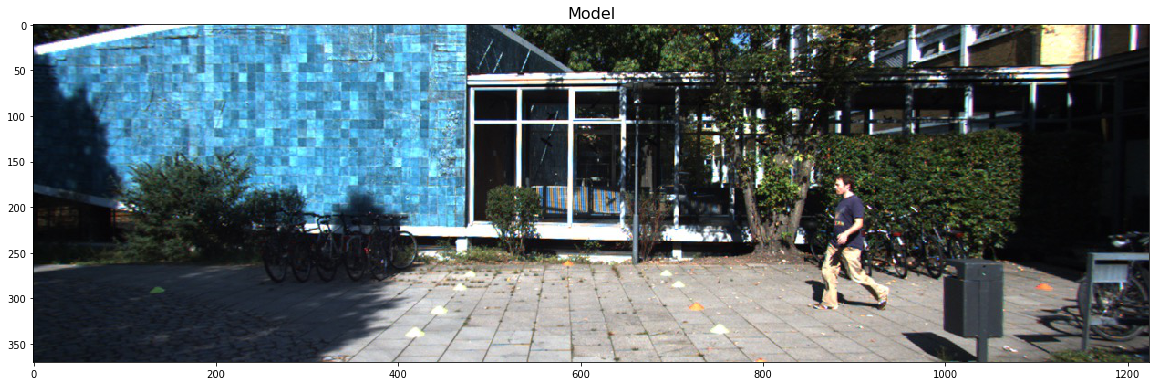

In [252]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        image_path = np.random.choice(paths)
        image = Image.open(image_path)
        image_np = load_image_into_numpy_array(image)
        image_process = detect_objects(image_np, sess, detection_graph)
        plt.figure(figsize=FIGSIZE)
        plt.imshow(image_process)
        plt.title('Model', fontsize=16)
        plt.figure(figsize=FIGSIZE)
        plt.imshow(show_groundtruth(image_path))
        plt.title('Human Labels', fontsize=16)

In [70]:
# n/A 80%
# also wrong enough that maybe a bug?

In [244]:
def detect_objects(image_np, sess, detection_graph):
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

    # Each box represents a part of the image where a particular object was detected.
    boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    
    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result immage, together with the class label.
    scores = detection_graph.get_tensor_by_name('detection_scores:0')
    classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')

    # Actual detection.
    (boxes, scores, classes, num_detections) = sess.run(
        [boxes, scores, classes, num_detections],
        feed_dict={image_tensor: image_np_expanded})
    print(boxes[0][0])
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        np.squeeze(boxes),
        np.squeeze(classes).astype(np.int32),
        np.squeeze(scores),
        category_index,
        use_normalized_coordinates=True,
        line_thickness=8)
    return image_np

In [245]:
label_paths = glob.glob(os.path.join('kitti_data', '*','label_2', '*.txt'))

In [195]:

#label_paths

In [196]:
for path in label_paths:
    strip_leading_zeroes(path)

In [207]:
%load_ext autoreload
%autoreload 2
from create_dataset import create_records
from create_pascal_tf_record import dict_to_tf_example

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [211]:
from_kitti = {'image': {'path': 'kitti_data/training/image_2/2456.jpg', 'height': 370, 'segmented_path': None, 'id': '2456', 'width': 1224}, 'detections': [{'top': 136.7, 'left': 275.0, 'right': 353.9, 'bottom': 299.54, 'label': 'person'}]}

In [212]:
from create_pascal_tf_record import kitti_dict_to_tf_example

In [218]:
kitti_dict_to_tf_example(from_kitti)

features {
  feature {
    key: "image/encoded"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\000\000\001\000\001\000\000\377\333\000C\000\010\006\006\007\006\005\010\007\007\007\t\t\010\n\014\024\r\014\013\013\014\031\022\023\017\024\035\032\037\036\035\032\034\034 $.\' \",#\034\034(7),01444\037\'9=82<.342\377\333\000C\001\t\t\t\014\013\014\030\r\r\0302!\034!22222222222222222222222222222222222222222222222222\377\300\000\021\010\001r\004\310\003\001\"\000\002\021\001\003\021\001\377\304\000\037\000\000\001\005\001\001\001\001\001\001\000\000\000\000\000\000\000\000\001\002\003\004\005\006\007\010\t\n\013\377\304\000\265\020\000\002\001\003\003\002\004\003\005\005\004\004\000\000\001}\001\002\003\000\004\021\005\022!1A\006\023Qa\007\"q\0242\201\221\241\010#B\261\301\025R\321\360$3br\202\t\n\026\027\030\031\032%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\203\204\205\206\207\210\211\212\222\223\224\225\226\227\230\231\232\242\243\244\245\246\247

In [210]:
#create_records()

../object_detection/utils/dataset_util.py:75: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not xml:


{0: ['person'],
 1: ['car', 'car', 'DontCare'],
 2: ['car', 'car', 'car', 'car', 'car', 'DontCare', 'DontCare', 'DontCare'],
 3: ['car',
  'car',
  'car',
  'car',
  'car',
  'car',
  'car',
  'car',
  'car',
  'car',
  'car',
  'Van',
  'car',
  'car'],
 4: ['car',
  'car',
  'car',
  'Cyclist',
  'Cyclist',
  'person',
  'car',
  'car',
  'Van',
  'car',
  'car',
  'Van',
  'Van']}

[ 0.01188183  0.          0.98302406  0.94844353]
[(1, 4), (100,), (100,)]


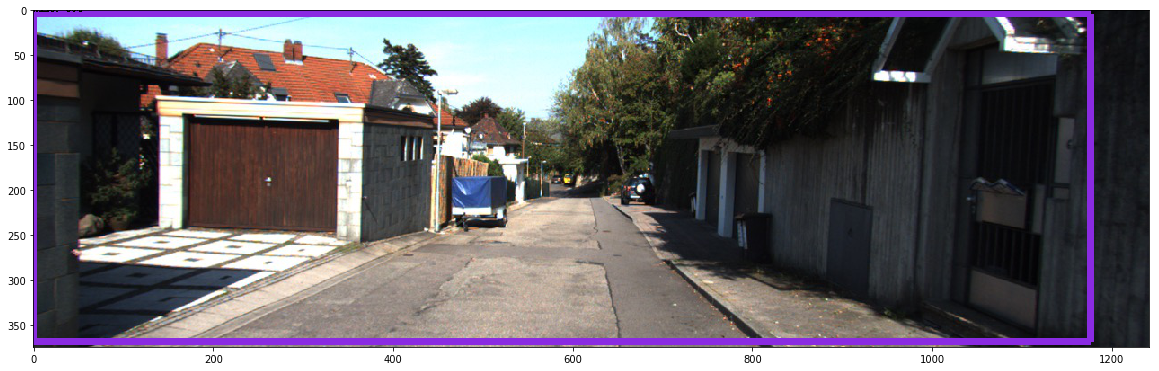

### Kitti Port

In [ ]:
import glob
images = glob.glob('/Users/shleifer/kitti_trunc/training/image_2/*')


In [ ]:
labels = glob.glob('/Users/shleifer/kitti_trunc/training/label_2/*')

In [ ]:
dets = glob.glob('/Users/shleifer/kitti_trunc/training/det_2/*')

In [75]:
orig_image_paths = glob.glob('/Users/shleifer/kitti_data/training/image_2/*.png')

In [53]:
from create_dataset import convert_to_jpg_and_save
%load_ext autoreload
%autoreload 2

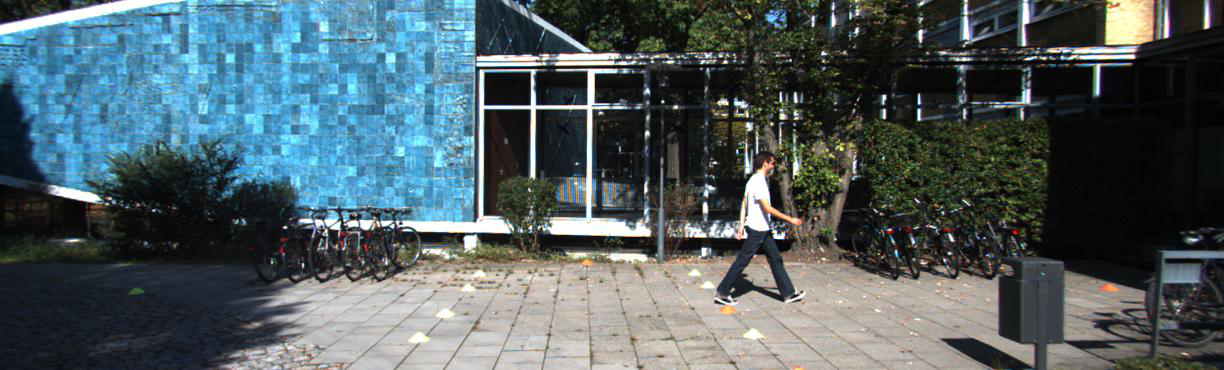

In [88]:
def convert_to_jpg_and_save(png_path):
    im = Image.open(png_path)
    rgb_im = im.convert('RGB')
    new_path = '{}.jpg'.format(png_path[:-4])
    rgb_im.save(new_path)
    return new_path
Image.open(convert_to_jpg_and_save(orig_image_paths[0]))

In [ ]:
ls /Users/shleifer/kitti_trunc/training/

In [ ]:
!cat {labels[0]}

In [ ]:
file_contents = ','.join(
    [os.path.basename(x)[:-4] for x in np.random.choice(images, 100)])

In [ ]:
file_contents

In [ ]:
with open('/Users/shleifer/kitti_trunc/train.txt', 'w') as f:
    f.write(file_contents)

In [ ]:
import shutil

In [ ]:
#shutil.move?

In [ ]:
#dets[0]

In [ ]:
from os import path as p

In [ ]:
labels[0]

In [ ]:
len('000000')

In [ ]:
import pandas as pd
pd.value_counts(list(map(lambda x: len(os.path.basename(x)),images)))

In [ ]:
Image.open(images[0])

In [ ]:
root_dir = '/Users/shleifer/voc_kitti/VOC2012/'
img_dir = os.path.join(root_dir, 'JPEGImages')
ann_dir = os.path.join(root_dir, 'Annotations')
set_dir = os.path.join(root_dir, 'ImageSets', 'Main')

In [ ]:
labels = glob.glob('/Users/shleifer/kitti_trunc/training/label_2/*')

In [ ]:
xml_p = glob.glob('/Users/shleifer/voc_kitti/VOC2012/Annotations/1023.xml')[0]

In [ ]:
voc_annot = tf.gfile.GFile(xml_p, 'r').read()

In [ ]:
%load_ext autoreload
%autoreload 2
from create_pascal_tf_record import dict_to_tf_example

In [ ]:
import sys; sys.path.append('..')

In [ ]:
from object_detection.create_pascal_tf_record import dict_to_tf_example

In [ ]:
dataset_directory =  '/Users/shleifer/voc_kitti/'
image_subdirectory='JPEGImages'

In [157]:
from object_detection.utils import dataset_util
from object_detection.utils import label_map_util
import hashlib
import io
import logging
import os

from lxml import etree
import PIL.Image
import tensorflow as tf


writer = tf.python_io.TFRecordWriter('data/train.tfrecord')
label_map_dict = label_map_util.get_label_map_dict('data/my_map.pbtxt')
annotations_dir = '/Users/shleifer/voc_kitti/VOC2012/Annotations/'
examples_path = '/Users/shleifer/voc_kitti/VOC2012/ImageSets/Main/trainval.txt'


examples_path = '/Users/shleifer/voc_kitti/VOC2012/ImageSets/Main/trainval.txt'

#examples_list

def create_records(examples_path):
    examples_list = dataset_util.read_examples_list(examples_path)
    for example in examples_list[1:11]:
        path = os.path.join(annotations_dir, example + '.xml')
        #print(path)
        with tf.gfile.GFile(path, 'r') as fid:
            xml_str = fid.read()
        xml = etree.fromstring(xml_str)
        data = dataset_util.recursive_parse_xml_to_dict(xml)['annotation']
        tf_example = dict_to_tf_example(data, 
                                        dataset_directory,
                                        label_map_dict,
                                        False)
        writer.write(tf_example.SerializeToString())
    writer.close()

NotFoundError: data/my_map.pbtxt

In [95]:
create_records(examples_path)

../object_detection/utils/dataset_util.py:75: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not xml:


In [85]:
data['folder']

'VOC2012'

In [ ]:
os.path.join('/Users/shleifer/voc_kitti/VOC2012/JPEGImages/')

In [84]:
data['filename']

'5308.jpg'

In [ ]:
f = 'data/train.tfrecord'
for serialized_example in tf.python_i o.tf_record_iterator(f):
    example = tf.train.Example()
    example.ParseFromString(serialized_example)
    print(example)
    break

    # Read data in specified format
    label = example.features.feature["image/object/class/label"].float_list.value
    ids = example.features.feature["ids"].int64_list.value
    values = example.features.feature["values"].float_list.value
    print(label, id, values)

In [ ]:
example.features.feature.keys()

In [ ]:
Image.open('/Users/shleifer/voc_kitti/VOC2012/JPEGImages/5308.jpg')

In [ ]:
ls data/train.tfrecord

In [ ]:
#examples_list

In [ ]:
label_map_dict

In [ ]:
data['object']

In [ ]:
#full_path

In [ ]:
  with tf.gfile.GFile(full_path, 'rb') as fid:
    encoded_jpg = fid.read()

In [ ]:
import io
encoded_jpg

In [ ]:
from cv2 import imread

In [ ]:
import io

In [ ]:
img_path = os.path.join(data['folder'], image_subdirectory, data['filename'])
full_path = os.path.join(dataset_directory, img_path)

In [ ]:
data['folder']

In [ ]:
/Users/shleifer/voc_kitti/VOC2012/JPEGImages/

In [ ]:
data

In [ ]:
dict_to_tf_example()

In [ ]:
examples_path = '~/sh'

In [ ]:
ls data

In [ ]:
!cat {labels[0]}

In [ ]:
# list image sets
all_files = !ls {set_dir}
image_sets = sorted(list(set([filename.replace('.txt', '').strip().split('_')[0] for filename in all_files])))
image_sets

In [ ]:
ann_dir